### Установка зависимостей

In [ ]:

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
import PIL
print(PIL.__version__)

9.5.0


In [ ]:
!unzip -q /content/drive/MyDrive/journey-springfield.zip



unzip:  cannot find or open /content/drive/MyDrive/journey-springfield.zip, /content/drive/MyDrive/journey-springfield.zip.zip or /content/drive/MyDrive/journey-springfield.zip.ZIP.


In [ ]:
!ls train

ls: cannot access 'train': No such file or directory


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Wed Nov 22 19:40:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    28W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
             transforms.ToTensor(),
             #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
             transforms.RandomRotation(degrees=(-10, 10)),
             transforms.RandomAutocontrast(),
             transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
             transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), antialias=True),
             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('/kaggle/input/journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('/kaggle/input/journey-springfield/testset/testset')

In [ ]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.

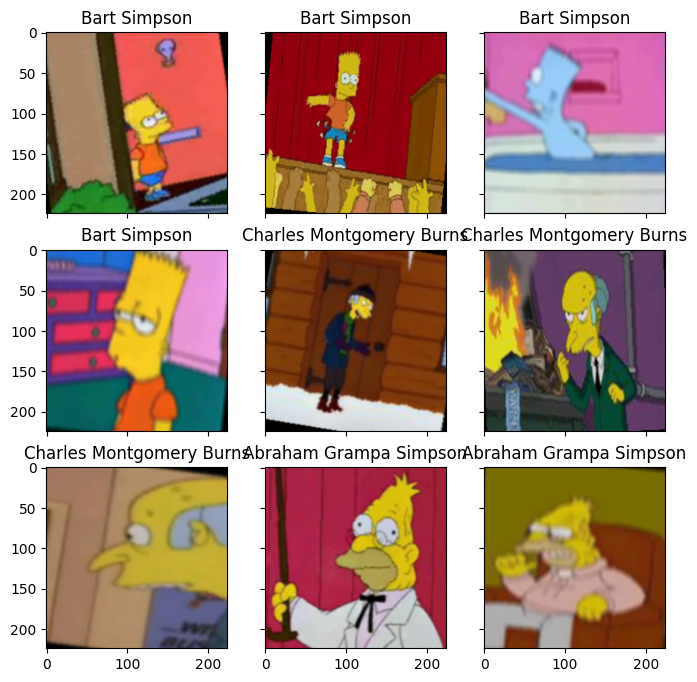

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

# Оценим размер обучающей выборки

In [ ]:
len(train_files)

15699

# Зафиксируем случайное начальное состояние для PyTorch, CUDA и отключим автоматическую настройку cudnn для большей воспроизводимости эксперемента

Попробуем использовать предобученную модель Resnet

In [ ]:
import torch
import torch.backends.cudnn as cudnn
import numpy as np

# Зафиксируема случайное начальное состояние для PyTorch
torch.manual_seed(42)
np.random.seed(42)

# Если используем GPU, зафиксируем случайное начальное состояние для CUDA
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    cudnn.deterministic = True
    cudnn.benchmark = False  # Отключить автоматическую настройку cudnn для воспроизводимости


In [ ]:
import torchvision.models as models
import torch.nn as nn


model = models.resnet50(weights="ResNet50_Weights.DEFAULT")
model.fc

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 280MB/s]


Linear(in_features=2048, out_features=1000, bias=True)

#Меняем выходной слой в соответсвии с количестом классов

In [ ]:
model.fc = nn.Linear(2048, 42)

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = model.to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_siz

Запустим обучение сети.

# У нас 42 класса, поэтому мы ввели ранее это количество классов в последний слой Resnet50

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

# Замораживаем параметры слоев c batchnormalisation, иначе точность обучения будет значительно падать после первого слоя разморозки, размороженными оставлям последние три слоя

In [ ]:
# Замораживаем параметры слоев
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# Размораживаем параметры 3 последних слоев начиная с layer4
layers = list(model.children())
for layer in layers[-3:]:
    for param in layer.parameters():
        param.requires_grad = True

In [ ]:
# Замораживаем параметры слоев с нормализаций батча
for name, param in model.named_parameters():
    if 'bn' in name:  # Проверяем, содержится ли 'bn' в имени параметра
        param.requires_grad = False


In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=15, batch_size=128)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 0.8439364149749822


epoch:   7%|▋         | 1/15 [06:23<1:29:23, 383.10s/it]


Epoch 001 train_loss: 0.8439     val_loss 0.3596 train_acc 0.7990 val_acc 0.9091
loss 0.43889880847252055


epoch:  13%|█▎        | 2/15 [10:57<1:09:08, 319.14s/it]


Epoch 002 train_loss: 0.4389     val_loss 0.4052 train_acc 0.8876 val_acc 0.8940
loss 0.254624476586909


epoch:  20%|██        | 3/15 [15:35<1:00:06, 300.58s/it]


Epoch 003 train_loss: 0.2546     val_loss 0.2738 train_acc 0.9335 val_acc 0.9312
loss 0.1995354448638833


epoch:  27%|██▋       | 4/15 [20:08<53:02, 289.34s/it]


Epoch 004 train_loss: 0.1995     val_loss 0.2520 train_acc 0.9453 val_acc 0.9389
loss 0.14776135352156908


epoch:  33%|███▎      | 5/15 [24:40<47:13, 283.39s/it]


Epoch 005 train_loss: 0.1478     val_loss 0.2459 train_acc 0.9607 val_acc 0.9354
loss 0.1272139251066041


epoch:  40%|████      | 6/15 [29:19<42:16, 281.87s/it]


Epoch 006 train_loss: 0.1272     val_loss 0.2074 train_acc 0.9646 val_acc 0.9473
loss 0.12058229176611747


epoch:  47%|████▋     | 7/15 [33:56<37:21, 280.19s/it]


Epoch 007 train_loss: 0.1206     val_loss 0.2176 train_acc 0.9689 val_acc 0.9478
loss 0.10636202076854459


epoch:  53%|█████▎    | 8/15 [38:33<32:33, 279.07s/it]


Epoch 008 train_loss: 0.1064     val_loss 0.2216 train_acc 0.9712 val_acc 0.9461
loss 0.08690864781250095


epoch:  60%|██████    | 9/15 [43:22<28:12, 282.12s/it]


Epoch 009 train_loss: 0.0869     val_loss 0.2401 train_acc 0.9746 val_acc 0.9412
loss 0.08561839386265524


epoch:  67%|██████▋   | 10/15 [47:57<23:19, 280.00s/it]


Epoch 010 train_loss: 0.0856     val_loss 0.2327 train_acc 0.9778 val_acc 0.9513
loss 0.0828769157520031


epoch:  73%|███████▎  | 11/15 [52:35<18:37, 279.36s/it]


Epoch 011 train_loss: 0.0829     val_loss 0.2147 train_acc 0.9787 val_acc 0.9490
loss 0.07166797035541099


epoch:  80%|████████  | 12/15 [57:31<14:13, 284.56s/it]


Epoch 012 train_loss: 0.0717     val_loss 0.1829 train_acc 0.9807 val_acc 0.9583
loss 0.0684217519498614


epoch:  87%|████████▋ | 13/15 [1:02:02<09:20, 280.25s/it]


Epoch 013 train_loss: 0.0684     val_loss 0.2106 train_acc 0.9815 val_acc 0.9507
loss 0.06370642362017127


epoch:  93%|█████████▎| 14/15 [1:06:40<04:39, 279.67s/it]


Epoch 014 train_loss: 0.0637     val_loss 0.1750 train_acc 0.9818 val_acc 0.9620
loss 0.05719610890375367


epoch: 100%|██████████| 15/15 [1:11:20<00:00, 285.38s/it]


Epoch 015 train_loss: 0.0572     val_loss 0.2148 train_acc 0.9835 val_acc 0.9505


Построим кривые обучения

In [ ]:
%cd /kaggle/working
model = simple_cnn
model_path = '/kaggle/working/model.pth'

# Сохраним модель в файл
torch.save(model.state_dict(), model_path)

/kaggle/working


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

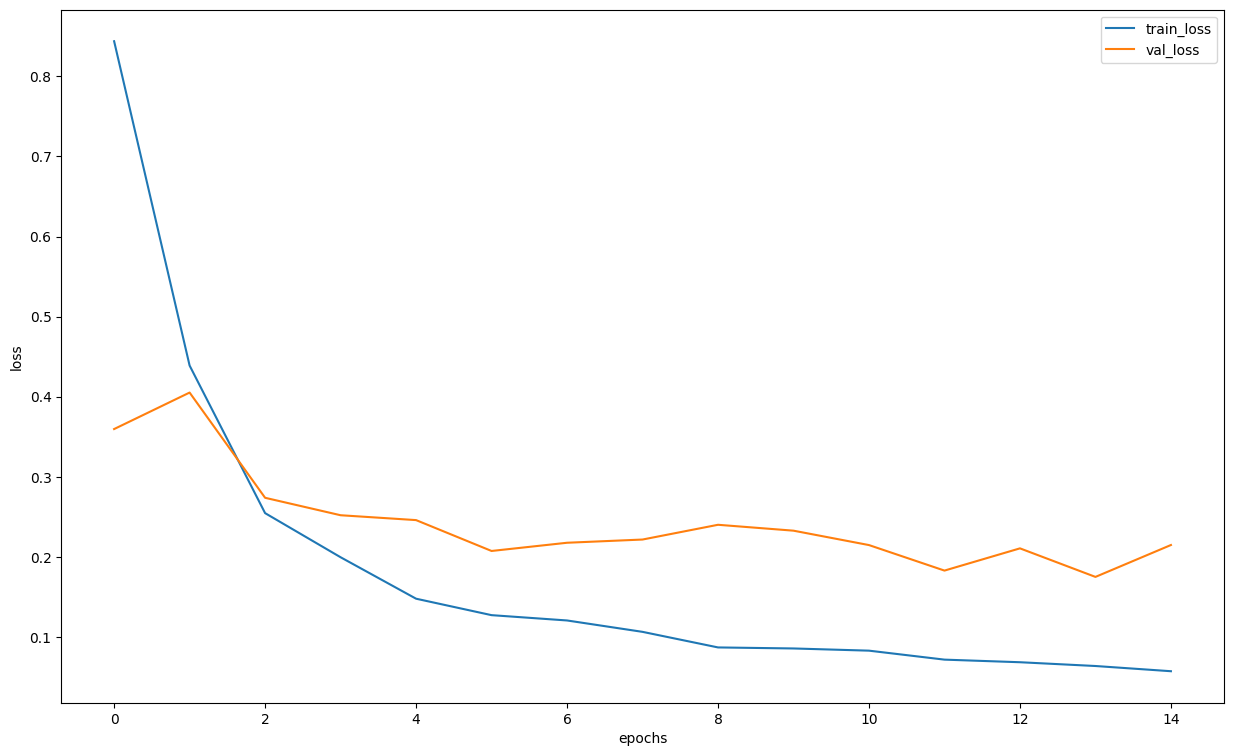

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)


F1-оценка: 1.0


Визуализация с вроятностью прдсказания, чтобы посмотреть насколько сеть уверена в своих ответах.

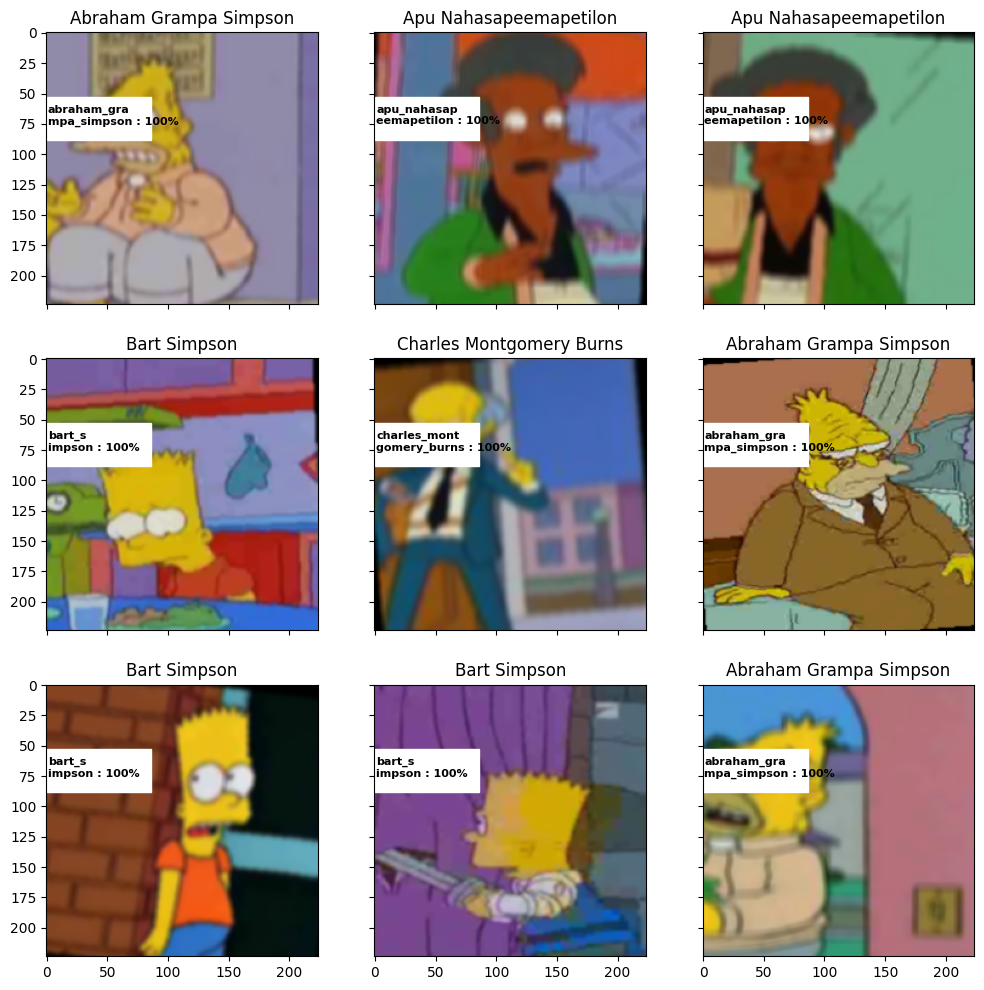

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [ ]:

test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]






In [ ]:
! ls

__notebook__.ipynb  label_encoder.pkl  model.pth


In [ ]:
import pandas as pd
#my_submit = pd.read_csv("/kaggle/input/sample_submission.csv")
my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()

,Image_id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)
my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})

In [ ]:
!cd /kaggle/working

In [ ]:
my_submit.to_csv('/kaggle/working/my_submission.csv', index=False)

In [ ]:
df = pd.read_csv("/kaggle/working/my_submission.csv")
df.head(-1)

,Image_id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
...,...,...
985,img986.jpg,sideshow_bob
986,img987.jpg,nelson_muntz
987,img988.jpg,ned_flanders
988,img989.jpg,charles_montgomery_burns


In [ ]:
model = simple_cnn
model_path = '/kaggle/working/model1.pth'

# Сохраним модель в файл
torch.save(model.state_dict(), model_path)